# Mínimos cuadrados

Aqui se introduce la idea de ajustar un modelo a los datos.
En este contexto, un **modelo** consiste en una descripción matemática de la relación entre variables, como una **línea recta**, y una descripción de la variación aleatoria, como una distribución normal.

Cuando decimos que un modelo se ajusta a los datos, normalmente nos referimos a que minimiza los errores, que son las distancias entre el modelo y los datos.
Comenzaremos con una de las formas más utilizadas de ajustar un modelo, minimizando la suma de los errores al cuadrado, lo que se denomina ajuste por mínimos cuadrados.

También comenzaremos con modelos que funcionan con solo dos variables a la vez.

In [1]:
from os.path import basename, exists
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Ajuste por mínimos cuadrados

Supongamos que eres un investigador en la Antártida y estás estudiando las poblaciones locales de pingüinos.
Como parte de su recopilación de datos, captura una muestra de pingüinos, los mide y los pesa, y luego los libera ilesos.

Puede ser difícil conseguir que los pingüinos permanezcan en la báscula el tiempo suficiente para obtener una medición precisa.
Supongamos que para algunos pingüinos tenemos mediciones como el tamaño de las aletas y el pico, pero no el peso.
Veamos si podemos utilizar las otras mediciones para completar los datos que faltan; este proceso se denomina **imputación**.

Comenzaremos explorando la relación entre el peso y las mediciones, utilizando los datos recopilados entre 2007 y 2010 por investigadores de la estación Palmer en la Antártida.

La siguiente celda descarga los datos de un repositorio creado por Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

Los datos se recopilaron como parte de la investigación que dio lugar a este artículo: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

Podemos usar `read_csv` de `pandas` para leer la informacion.

In [3]:
url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"

penguins = pd.read_csv(url).dropna(subset=["Body Mass (g)"])
penguins.shape

(342, 17)

El conjunto de datos incluye mediciones de **151** pingüinos Adelia (`Adélie`).
Podemos utilizar `query` para seleccionar las filas que contienen estos datos.

In [4]:
adelie = penguins.query('Species.str.startswith("Adelie")')
len(adelie)

151

Ahora supongamos que conocemos la longitud de las aletas de un pingüino Adelia. Veamos qué tan bien podemos predecir su peso.

Primero seleccionaremos estas columnas del `DataFrame`.

In [5]:
flipper_length = adelie["Flipper Length (mm)"]
body_mass = adelie["Body Mass (g)"]

Aquí hay un diagrama de dispersión (`scatter plot`) que muestra la relación entre estas cantidades.

Text(0, 0.5, 'Body Mass (g)')

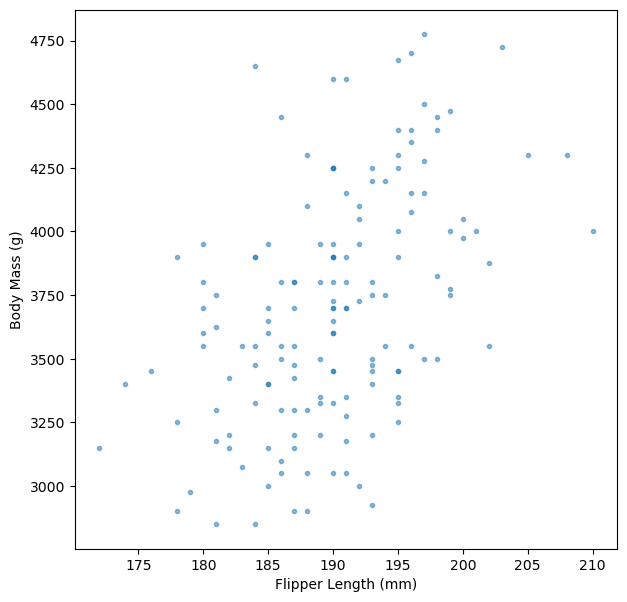

In [6]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
plt.xlabel("Flipper Length (mm)")
plt.ylabel("Body Mass (g)")

Parece que están relacionadas; podemos cuantificar la fuerza de la relación calculando el coeficiente de correlación. Podemos usar la funcion **`corrcoef`** de `numpy` que devuelve los coeficientes de correlación de Pearson.

In [7]:
np.corrcoef(flipper_length, body_mass)

array([[1.        , 0.46820169],
       [0.46820169, 1.        ]])

La correlación es de aproximadamente **`0.47`**, por lo que los pingüinos con aletas más largas tienden a ser más pesados.
Esto es útil porque significa que podemos estimar el peso de un pingüino con mayor precisión si conocemos la longitud de sus aletas, pero la correlación por sí sola no nos dice cómo hacer esas estimaciones.
Para ello, necesitamos elegir una **línea de mejor ajuste**.

Hay muchas formas de definir la línea "óptima", pero para datos como estos, una opción habitual es el ajuste **lineal por mínimos cuadrados**, que es la línea recta que minimiza el **error cuadrático medio** (`MSE`).

`SciPy` proporciona una función llamada **`linregress`** que calcula un ajuste por mínimos cuadrados.
El nombre es la abreviatura de **regresión lineal**, que es otro término para un modelo como este.

Los argumentos de `linregress` son los valores `x` y los valores `y`, en ese orden.

In [8]:
from scipy.stats import linregress

result = linregress(flipper_length, body_mass)
result

LinregressResult(slope=32.83168975115009, intercept=-2535.8368022002514, rvalue=0.46820169421793933, pvalue=1.3432645947790051e-09, stderr=5.076138407990821, intercept_stderr=964.7984274994059)

El resultado es un objeto `LinregressResult` que contiene la pendiente y la intersección de la línea ajustada, junto con otra información que veremos en breve.

```
slope, intercept, r_value, p_value, std_err, intercept_stderr = stats.linregress(x, y)
```

La pendiente es de aproximadamente `32.8`, lo que significa que cada milímetro adicional de longitud de la aleta se asocia con `32.8` gramos adicionales de peso corporal.

La **intercepto** (bias) es de `-2,535` gramos, lo que puede parecer absurdo, ya que un peso medido no puede ser negativo.
Podría tener más sentido si utilizamos la **pendiente** y la **intercepto** para evaluar la línea ajustada en la longitud media de la aleta.

In [9]:
x = flipper_length.mean()
y = result.intercept + result.slope * x
print(f"Media longitud de aleta: {x:3f}, Peso predicho para la media de la aleta: {y:3f}")

Media longitud de aleta: 189.953642, Peso predicho para la media de la aleta: 3700.662252


Para un pingüino con una longitud media de aleta de unos `190 mm`, el peso corporal esperado es de unos `3,700 gramos`.

La siguiente función toma el resultado de `linregress` y una secuencia de `xs` y encuentra el punto en la línea ajustada para cada valor de `x`.

In [10]:
def predict(result, xs):
    ys = result.intercept + result.slope * xs
    return ys

El nombre `predict` puede parecer extraño aquí: en lenguaje natural, una **predicción** suele referirse a algo que sucederá en el futuro, pero en el contexto de la regresión, los puntos de la línea ajustada también se denominan predicciones.

Podemos utilizar `predict` para calcular los puntos de la línea para un rango de tamaños de aletas.

In [11]:
fit_xs = np.linspace(np.min(flipper_length), np.max(flipper_length))
fit_ys = predict(result, fit_xs)

Aquí está la línea ajustada junto con el **diagrama de dispersión** (scatter plot) de los datos.

Text(0, 0.5, 'Body Mass (g)')

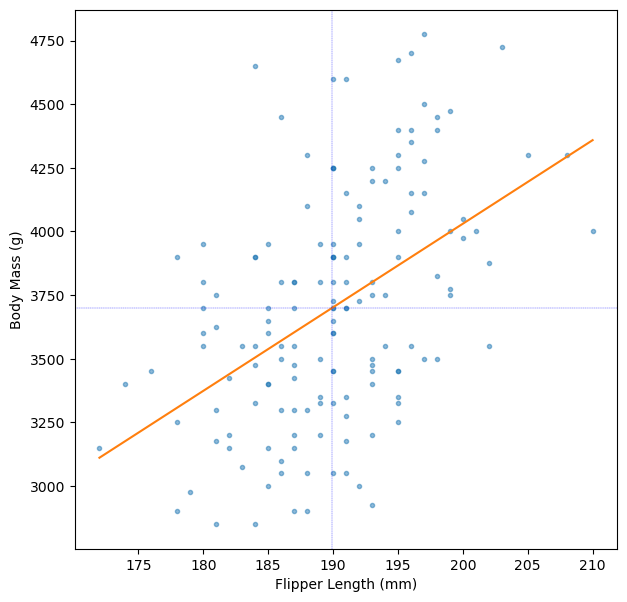

In [12]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1")

plt.axvline(x=flipper_length.mean(), color='b', linestyle='--', linewidth=0.25, label='mean x')
plt.axhline(y=body_mass.mean(), color='b', linestyle='--', linewidth=0.25, label='mean y')

plt.xlabel("Flipper Length (mm)")
plt.ylabel("Body Mass (g)")

Como era de esperar, la línea ajustada pasa por el centro de los datos y sigue la tendencia.
Y algunas de las predicciones son precisas, pero muchos de los puntos de datos están lejos de la línea.

Para tener una idea de lo buenas (o malas) que son las predicciones, podemos calcular el **error de predicción**, que es la distancia vertical de cada punto con respecto a la línea.
La siguiente función calcula estos errores, que también se denominan **residuos**.

In [13]:
def compute_residuals(result, xs, ys):
    fit_ys = predict(result, xs)
    return ys - fit_ys

Aquí están los residuos para la **masa corporal** en función de la **longitud de las aletas**.

In [14]:
residuals = compute_residuals(result, flipper_length, body_mass)

Como ejemplo, podemos ver los resultados del primer pingüino del conjunto de datos.

In [15]:
x = flipper_length[0]
y = predict(result, x)

print(f"Media longitud de aleta: {x:3f}, Peso predicho para la media de la aleta: {y:3f}")

Media longitud de aleta: 181.000000, Peso predicho para la media de la aleta: 3406.699043


La **longitud de la aleta** del pingüino seleccionado es de `181 mm` y la **masa corporal** prevista es de `3407 gramos`.

Ahora veamos cuál es la masa real.

In [16]:
print(f"Masa corporal real: {body_mass[0]:3f}, residuos de la prediccion: {residuals[0]:3f}")

Masa corporal real: 3750.000000, residuos de la prediccion: 343.300957


La **masa real** de este pingüino es de `3,750 gramos`, y el **residuo** (después de restar la predicción) es de `343 gramos`.

El promedio de los residuos al cuadrado es el **error cuadrático medio** (`MSE`) de las predicciones.

In [17]:
mse = np.mean(residuals**2)

print(f"Error Cuadrático Medio (MSE): {mse:3f}")

Error Cuadrático Medio (MSE): 163098.859029


Por sí solo, este número no significa gran cosa.

Podemos darle más sentido calculando el **coeficiente de determinación**, $R^2$.

## Coeficiente de determinación $R^2$

Supongamos que quieres adivinar el **peso** de un pingüino.
Si sabes la **longitud de sus aletas**, puedes usar la recta de regresión por mínimos cuadrados para hacer una predicción informada. La calidad de esas predicciones se mide con el **error cuadrático medio** (**MSE**): cuanto más pequeño sea, mejor estás acertando en promedio.

Ahora, piensa: **¿qué pasaría si no tuvieras ninguna información sobre las aletas?**
La mejor apuesta sería usar la media de los pesos de todos los pingüinos. Esta estrategia, aunque básica, también es óptima: garantiza el MSE más bajo posible cuando no hay variables explicativas. En ese caso, los errores de predicción no son otra cosa que las desviaciones respecto a la media.

Si siempre estimamos la media, los errores de predicción son las desviaciones de la media.

In [18]:
deviations = body_mass - np.mean(body_mass)

Y la MSE es la desviación cuadrática media.

In [19]:
np.mean(deviations**2).item()

208890.28989956583

Quizás recuerdes que la desviación cuadrática media es la varianza.

In [20]:
np.var(body_mass)

208890.28989956572

Así, la varianza de los pesos refleja el MSE de esta estrategia “ingenua” de predecir siempre la media.
En cambio, cuando sí usamos la longitud de las aletas y ajustamos la recta de regresión, el MSE de los errores se convierte en la varianza de los residuos.

La clave está en comparar ambas situaciones:

* Varianza total de los pesos (sin usar las aletas) = error si siempre predices la media.

* Varianza de los residuos (usando las aletas) = error al usar la regresión.

La reducción relativa del error se captura en esta razón:

$$
R^2 = 1-\frac{S_e^2}{S_y^2}
$$

Este número nos dice qué tanto mejoramos nuestras predicciones al usar la variable independiente (aletas) en lugar de simplemente la media.
Técnicamente se llama **coeficiente de determinación**, pero como su símbolo es $R^2$, casi todo el mundo lo conoce como “R al cuadrado”.

In [21]:
def coefficient_of_determination(ys, residuals):
    return 1 - np.var(residuals) / np.var(ys)

En el ejemplo, $R^2$ es aproximadamente `0.22`, lo que significa que la línea ajustada reduce el MSE en un **22%**.

In [22]:
R2 = coefficient_of_determination(body_mass, residuals)
R2

0.21921282646854823

In [23]:
result.rvalue.item()**2

0.21921282646854875

Resulta que existe una relación entre el coeficiente de determinación, $R^2$, y el coeficiente de correlación, $Cor(X,Y)$.
Como se puede deducir de la notación, $Cor(X,Y)^2 = R^2$.

Podemos demostrar que esto es cierto calculando la raíz cuadrada de $R^2$.

In [24]:
r = np.sqrt(R2)
r.item()

0.4682016942179388

Y comparándolo con la correlación que calculamos anteriormente.

In [25]:
corr = np.corrcoef(flipper_length, body_mass)[0, 1]
corr.item()

0.4682016942179394

Son iguales, salvo por una pequeña diferencia debida a la aproximación de coma flotante.

La función **`linregress`** también calcula este valor y lo devuelve como un atributo en el objeto `RegressionResult`.

In [26]:
result.rvalue.item()

0.46820169421793933

Los coeficientes de determinación y correlación transmiten prácticamente la misma información, pero se interpretan de manera diferente:

* La correlación cuantifica la fuerza de la relación en una escala de -1 a 1.

* $R^2$ cuantifica la capacidad de la línea ajustada para reducir el MSE.

Además, $R^2$ siempre es positivo, por lo que no indica si la correlación es positiva o negativa.

## Minimizar el MSE

Anteriormente se dijo que el ajuste por mínimos cuadrados es **la línea recta que minimiza el error cuadrático medio** (MSE).

No lo demostraremos matematicamente en este notebook, pero podemos comprobarlo añadiendo pequeños valores aleatorios a la **intersección** y la **pendiente**, y **verificando si el MSE empeora**.

In [27]:
intercept = result.intercept + np.random.normal(0, 1)
slope = result.slope + np.random.normal(0, 1)

Para ejecutar la prueba, necesitamos crear un objeto con los atributos `intercept` y `slope`; utilizaremos el objeto `SimpleNamespace` proporcionado por la libreria `types`.

In [28]:
from types import SimpleNamespace

fake_result = SimpleNamespace(intercept=intercept, slope=slope)
fake_result

namespace(intercept=-2534.549143384669, slope=32.52290986161345)

Podemos pasar este objeto a `compute_residuals` y utilizar los residuos para calcular el **MSE**.

In [29]:
def predict(result, xs):
    ys = result.intercept + result.slope * xs
    return ys

In [30]:
def compute_residuals(result, xs, ys):
    fit_ys = predict(result, xs)
    return ys - fit_ys

In [31]:
fake_residuals = compute_residuals(fake_result, flipper_length, body_mass)
fake_mse = np.mean(fake_residuals**2)

Si comparamos el resultado con el MSE de la línea de mínimos cuadrados, siempre es peor.

In [37]:
print(f"MSE: {mse:3f}, MSE truqueado: {fake_mse:3f}, Valor de MSE mejor que MSE truqueado: {fake_mse > mse}")

MSE: 163098.859029, MSE truqueado: 166393.790988, Valor de MSE mejor que MSE truqueado: True


Minimizar el MSE está bien, pero no es la única definición de «óptimo».
Una alternativa es **minimizar los valores absolutos de los errores**.

Otra es minimizar la distancia más corta desde cada punto hasta la línea ajustada, lo que se denomina **"error total"**.

En algunos contextos, adivinar demasiado alto puede ser mejor (o peor) que adivinar demasiado bajo.
En ese caso, es posible que desee calcular una función de error para cada residuo y minimizar el error total.

Pero el ajuste por **mínimos cuadrados** se utiliza mucho más que estas alternativas, principalmente porque es eficiente de calcular.

$$
b_1 = \frac{\sum (x_i-\bar{x})(y_i-\bar{y})}{\sum (x_i-\bar{x})^2}
$$

$$
b_0 = \bar{y} - b_i \times \bar{x}
$$

La siguiente función muestra cómo.

In [38]:
def least_squares(xs, ys):
    xbar = np.mean(xs)
    ybar = np.mean(ys)

    xdev = xs - xbar
    ydev = ys - ybar

    slope = np.sum(xdev * ydev) / np.sum(xdev**2)
    intercept = ybar - slope * xbar

    return intercept.item(), slope.item()

Para probar esta función, volveremos a utilizar la longitud de las aletas y la masa corporal.

In [33]:
intercept, slope = least_squares(flipper_length, body_mass)

print(f"intercepto: {intercept:3f}, pendiente: {slope:3f}")

intercepto: -2535.836802, pendiente: 32.831690


Y podemos confirmar que obtenemos los mismos resultados que obtuvimos con `linregress`.

In [34]:
np.allclose([intercept, slope], [result.intercept, result.slope])

True

Minimizar el MSE tenía sentido cuando la eficiencia computacional era más importante que elegir el método más adecuado para el problema en cuestión.

Vale la pena considerar si los residuos al cuadrado son lo que conviene minimizar.

## Estimación

Los parámetros **`slope`** e **`intercept`** son estimaciones basadas en una muestra.
Al igual que otras estimaciones, son vulnerables al muestreo no representativo, al error de medición y a la variabilidad debida al muestreo aleatorio.

Como es habitual, es difícil cuantificar el efecto del muestreo no representativo y el error de medición.
Es más fácil **cuantificar el efecto del muestreo aleatorio**.

Una forma de hacerlo es mediante un remuestreo **bootstrapping**: trataremos la muestra como si fuera toda la población y extraeremos nuevas muestras, con reemplazo, de los datos observados.

La siguiente función toma un `DataFrame` y utiliza el método `sample` para remuestrear las filas y devolver un nuevo `DataFrame`.

In [35]:
def resample(df):
    n = len(df)
    return df.sample(n, replace=True)

Y la siguiente función toma un `DataFrame`, encuentra el ajuste por **mínimos cuadrados** y devuelve la **`pendiente`** de la línea ajustada.

In [36]:
def estimate_slope(df):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.slope

Podemos utilizar estas funciones para generar muchos conjuntos de datos simulados y calcular la **pendiente** de cada uno de ellos.

In [39]:
# Inicializar el generador de números aleatorios para obtener los mismos resultados cada vez.
np.random.seed(1)

In [40]:
resampled_slopes = [estimate_slope(resample(adelie)) for i in range(1001)]

El resultado es una muestra de la **distribución muestral** de la **pendiente**.
Así es como se ve.

In [41]:
from scipy.stats import gaussian_kde

def plot_kde(sample, name="estimated density", title="Funcion de densidad (PDF) estimada", xlabel="", ylabel="Densidad"):
    kde = gaussian_kde(sample)

    m, s = np.mean(sample), np.std(sample)
    domain = m - 4 * s, m + 4 * s

    eval_points = np.linspace(domain[0], domain[1], 500) #dominio
    pdf_values = kde.pdf(eval_points)

    plt.figure(figsize=(10, 8))
    plt.plot(eval_points, pdf_values, label=name) # Estimacion
    plt.axvline(m, color="gray", ls=":") #media de la muestra
    plt.text(m + 0.001, 0, f"Mean: {m:.3f}", rotation=90, va='center', ha='left') # Agrega texto cerca de la linea axvline
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

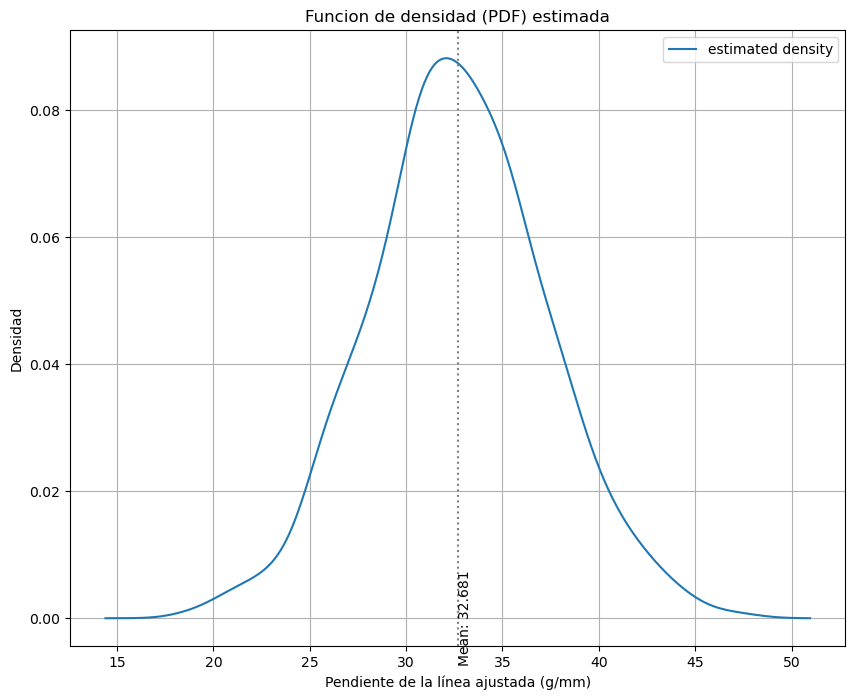

In [42]:
plot_kde(resampled_slopes, xlabel="Pendiente de la línea ajustada (g/mm)")

Podemos utilizar `percentile` para calcular un intervalo de confianza del **90%**.

In [43]:
ci90 = np.percentile(resampled_slopes, [5, 95])
print(f"Media Pendiente: {result.slope}, Intervalo de confianzos: {ci90}")

Media Pendiente: 32.83168975115009, Intervalo de confianzos: [25.39604591 40.21054526]


Por lo tanto, podríamos informar que la **pendiente** estimada es de `33 gramos/mm` con un **IC del 90%** `[25, 40] gramos/mm`.


Recordemos que el **`error estándar`** de la estimación es la **desviación estándar de la distribución muestral**.

In [44]:
stderr = np.std(resampled_slopes)

print(f"Error estandar: {stderr}")

Error estandar: 4.570238986584832


El objeto `RegressionResult` que obtuvimos de `linregress` proporciona una aproximación del **error estándar**, basada en algunas suposiciones sobre la forma de la distribución.

In [45]:
print(f"RegressionResult - Error estandar: {result.stderr}")

RegressionResult - Error estandar: 5.076138407990821


El error estándar que calculamos mediante el remuestreo es un poco menor, pero la diferencia probablemente no tenga importancia en la práctica.

## Visualización de la incertidumbre

Cada vez que **remuestreamos el conjunto de datos**, obtenemos una línea ajustada diferente.

Para ver cuánta variación hay en las líneas, una opción es recorrerlas y trazarlas todas.

La siguiente función toma un `DataFrame` remuestreado, calcula un ajuste por mínimos cuadrados y genera valores predichos para una secuencia de `xs`.

In [46]:
def fit_line(df, fit_xs):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    fit_ys = predict(result, fit_xs)
    return fit_ys

Aqui esta la secuencia de `xs` que usaremos.

In [47]:
xs = adelie["Flipper Length (mm)"]
fit_xs = np.linspace(np.min(xs), np.max(xs))

In [48]:
fit_xs.shape

(50,)

Y así es como se ven las líneas ajustadas, junto con un diagrama de dispersión (scatter plot) de los datos.

Text(0, 0.5, 'Body Mass (g)')

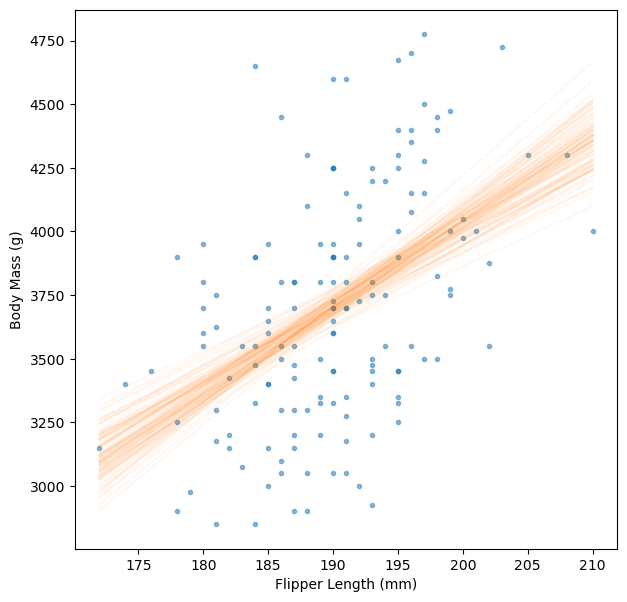

In [49]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

for i in range(101):
    fit_ys = fit_line(resample(adelie), fit_xs)
    plt.plot(fit_xs, fit_ys, color="C1", alpha=0.05)

plt.xlabel("Flipper Length (mm)")
plt.ylabel("Body Mass (g)")

Cerca del centro, las líneas ajustadas están muy juntas, mientras que en los extremos están más separadas.

Otra forma de representar la variabilidad de las líneas ajustadas es trazar un **intervalo de confianza del 90%** para cada valor previsto.

Podemos hacerlo recopilando las líneas ajustadas en una lista de matrices. Y así es como se ven las líneas ajustadas, junto con un diagrama de dispersión de los datos.

In [50]:
def resample(df):
    n = len(df)
    return df.sample(n, replace=True)

In [52]:
fitted_ys = [fit_line(resample(adelie), fit_xs) for i in range(1001)]

In [53]:
np.array(fitted_ys).shape

(1001, 50)

Podemos pensar en esta lista de matrices como una matriz bidimensional con una **fila para cada línea ajustada** y una **columna correspondiente a cada uno de los `xs`**.

Podemos utilizar `percentile` con el argumento `axis=0` para encontrar los percentiles 5, 50 y 95 de los `ys` correspondientes a cada uno de los `xs`.

In [54]:
low, median, high = np.percentile(fitted_ys, [5, 50, 95], axis=0)

In [55]:
np.array((low, median, high)).shape

(3, 50)

Ahora utilizaremos `fill_between` para trazar una región entre los **percentiles 5 y 95**, que representa el **IC del 90%**, junto con el valor **mediano** (`median`) de cada columna y un diagrama de dispersión de los datos.

Text(0, 0.5, 'Body Mass (g)')

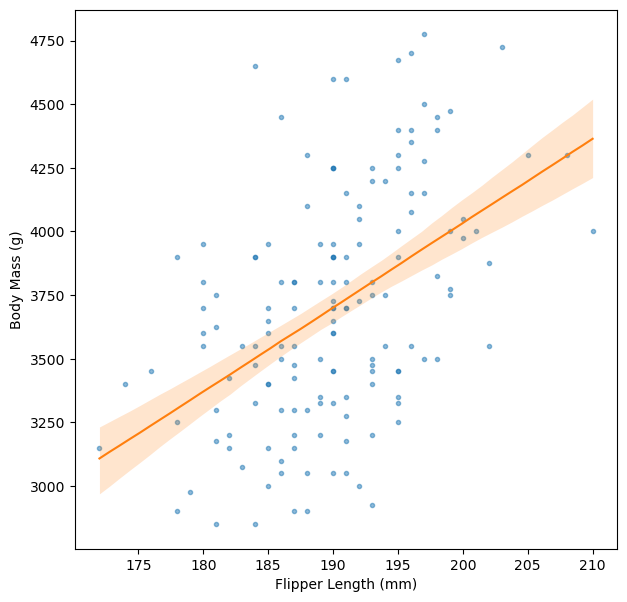

In [56]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

plt.fill_between(fit_xs, low, high, color="C1", lw=0, alpha=0.2) #relleno
plt.plot(fit_xs, median, color="C1") # linea

plt.xlabel("Flipper Length (mm)")
plt.ylabel("Body Mass (g)")

Esta es una forma de representar la variabilidad de una línea ajustada debido al muestreo aleatorio.



---


# EJERCICIOS

### Ejercicio 1

En este notebook hemos calculado un ajuste por **mínimos cuadrados** para el **peso de los pingüinos** en función de la **longitud de las aletas**.
Hay otras dos medidas en el conjunto de datos que también podemos tener en cuenta: la **longitud del culmen** y la **profundidad del culmen** (el culmen es la cresta superior del pico).

* Calcula el ajuste por **mínimos cuadrados** para el **peso** (`Body Mass (g)`) en función de la **longitud del culmen** (`Culmen Length (mm)`).
* Haga un diagrama de dispersión de estas variables y trace la línea ajustada.

Basándose en el atributo **`rvalue`** del objeto **`RegressionResult`**,
* ¿cuál es la correlación de estas variables?
* ¿Cuál es el coeficiente de determinación?

In [57]:
culmen_length = adelie["Culmen Length (mm)"]

body_mass = adelie["Body Mass (g)"]

In [58]:
# Ajuste por mínimos cuadrados para peso vs longitud del culmen
from scipy.stats import linregress
# Ajuste lineal
result_culmen = linregress(culmen_length, body_mass)

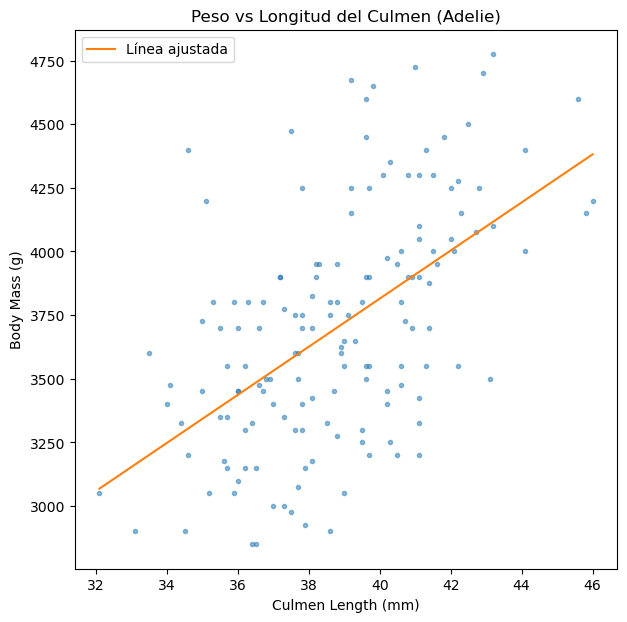

In [59]:
# Diagrama de dispersión y línea ajustada
fit_xs = np.linspace(np.min(culmen_length), np.max(culmen_length))
fit_ys = result_culmen.intercept + result_culmen.slope * fit_xs

plt.figure(figsize=(7, 7))
plt.scatter(culmen_length, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1", label="Línea ajustada")
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Body Mass (g)")
plt.legend()
plt.title("Peso vs Longitud del Culmen (Adelie)")
plt.show()

In [60]:
# Correlación y coeficiente de determinación
correlacion = result_culmen.rvalue
R2 = correlacion**2

print(f"Correlación (r): {correlacion:.3f}")
print(f"Coeficiente de determinación (R^2): {R2:.3f}")

Correlación (r): 0.549
Coeficiente de determinación (R^2): 0.301


Realice los pasos anteriores pero utilizando **profundidad del culmen** (`Culmen Depth (mm)`) para el **peso** (`Body Mass (g)`).

* ¿Cuál es un mejor predictor del peso, la longitud del culmen, profundidad del culmen o la longitud de las aletas?

In [62]:
culmen_depth = adelie["Culmen Depth (mm)"]

body_mass = adelie["Body Mass (g)"]

In [ ]:
# Obtener la regresión lineal por medio de mínimos cuadrados
result_depth = linregress(culmen_depth, body_mass)

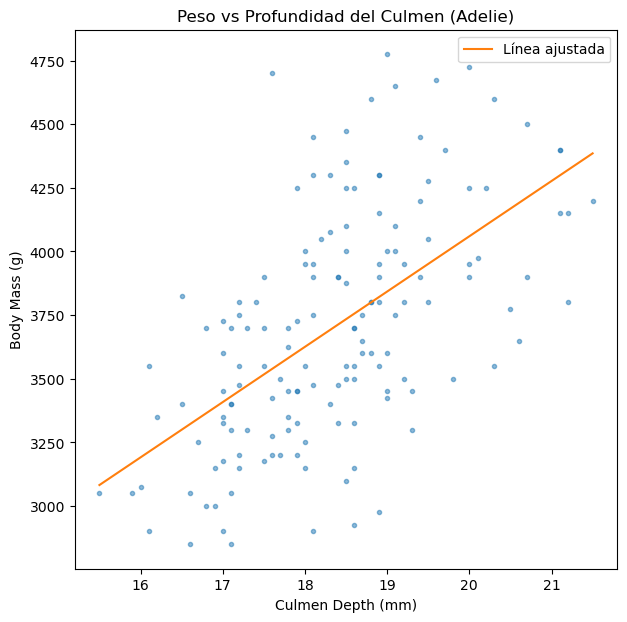

In [64]:
# Tu codigo va aqui
fit_xs = np.linspace(np.min(culmen_depth), np.max(culmen_depth))
fit_ys = result_depth.intercept + result_depth.slope * fit_xs

plt.figure(figsize=(7, 7))
plt.scatter(culmen_depth, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1", label="Línea ajustada")
plt.xlabel("Culmen Depth (mm)")
plt.ylabel("Body Mass (g)")
plt.legend()
plt.title("Peso vs Profundidad del Culmen (Adelie)")
plt.show()

In [ ]:
# Calculo de la correlación y coeficiente de determinación
correlacion_depth = result_depth.rvalue
R2_depth = correlacion_depth**2

print(f"Correlación (r) - Profundidad del Culmen: {correlacion_depth:.3f}")
print(f"Coeficiente de determinación (R^2) - Profundidad del Culmen: {R2_depth:.3f}")


Correlación (r) - Profundidad del Culmen: 0.576
Coeficiente de determinación (R^2) - Profundidad del Culmen: 0.332


### Ejercicio 2

En este notebook hemos utilizado el remuestreo para aproximar la distribución muestral de la pendiente de una línea ajustada. Podemos aproximar la **distribución muestral** de la intersección de la misma manera:

1. Escriba una función llamada **`estimate_intercept`** que tome como argumento un `DataFrame` remuestreado, calcule el ajuste por mínimos cuadrados del **peso** de los pingüinos en función de la **longitud de las aletas** y devuelva la **intersección**.

2. Llame a la función con muchas versiones remuestreadas de `adelie` y recopile las intersecciones.

3. Utilice **`plot_kde`** para trazar la distribución muestral de la intersección.

4. Calcule el **error estándar** y un **intervalo de confianza del 90%**.

5. Compruebe que el error estándar que obtiene del remuestreo es coherente con el atributo **`intercept_stderr`** del objeto **`RegressionResult`**; es posible que sea un poco menor.

In [66]:
# Funcion que estima la intersección de la regresión lineal
def estimate_intercept(df):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.intercept

In [71]:
# Llamar a la funcion con muchas versiones remuestradas de adelie
intercepts = [estimate_intercept(resample(adelie)) for _ in range(1000)]


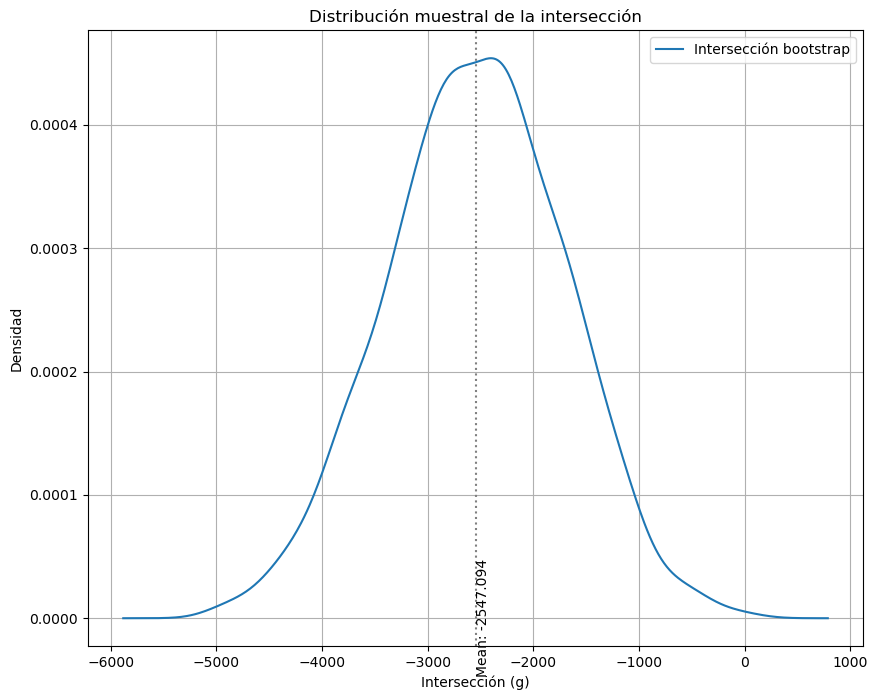

In [ ]:
# Graficar la distribución muestral de la intersección
plot_kde(
    intercepts,
    name="Intersección bootstrap",
    title="Distribución muestral de la intersección",
    xlabel="Intersección (g)",
    ylabel="Densidad"
)

In [69]:
# Error estándar de las intersecciones
stderr = np.std(intercepts)
print(f"Error estándar (bootstrap): {stderr:.2f}")

# Intervalo de confianza del 90%
ci90 = np.percentile(intercepts, [5, 95])
print(f"Intervalo de confianza 90%: [{ci90[0]:.2f}, {ci90[1]:.2f}]")

Error estándar (bootstrap): 826.98
Intervalo de confianza 90%: [-3772.31, -1202.43]


In [70]:
# Comparación con el error estándar de RegressionResult
print(f"Error estándar (RegressionResult): {result.intercept_stderr:.2f}")

Error estándar (RegressionResult): 964.80


### Ejercicio 3

El **índice de masa corporal** (*IMC*) de una persona es su **peso en kilogramos** dividido por su **estatura en metros elevada al cuadrado**.

En el **conjunto de datos BRFSS**, podemos calcular el **IMC** de esta manera, después de convertir las estaturas de centímetros a metros.

In [ ]:
from os.path import basename, exists
from urllib.request import urlretrieve
def download(url):
    filename = basename(url)
    if not exists(filename):
        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

In [ ]:
def clean_brfss(df):
    """Recodifica las variables BRFSS.
    Args:
        df: DataFrame que contiene los datos de BRFSS limpios.
    """
    df["age"] = df["age"].replace([7, 9], np.nan)
    df["htm3"] = df["htm3"].replace([999], np.nan)
    df["wtkg2"] = df["wtkg2"].replace([99999], np.nan) / 100
    df["wtyrago"] = df.wtyrago.replace([7777, 9999], np.nan)
    df["wtyrago"] = df.wtyrago.apply(lambda x: x / 2.2 if x < 9000 else x - 9000)

def read_brfss(filename="CDBRFS08.ASC.gz", compression="gzip", nrows=None):
    """Lee los datos BRFSS.
    Args:
        filename: string que indica la ruta al archivo de datos.
        compression: string que indica el tipo de compresión.
        nrows: número entero opcional que indica el número de filas que se van a leer, o None para leer todas.
    Returns:
        DataFrame: BRFSS data with cleaned variables.
    """
    # nombre y aspectos de columnas en
    # https://www.cdc.gov/brfss/annual_data/2008/varLayout_table_08.html
    var_info = [
        ("age", 100, 102, int),
        ("sex", 142, 143, int),
        ("wtyrago", 126, 130, int),
        ("finalwt", 798, 808, int),
        ("wtkg2", 1253, 1258, int),
        ("htm3", 1250, 1253, int),
    ]
    columns = ["name", "start", "end", "type"]
    variables = pd.DataFrame(var_info, columns=columns)

    colspecs = variables[["start", "end"]].values.tolist()
    names = variables["name"].tolist()

    df = pd.read_fwf(
        filename,
        colspecs=colspecs,
        names=names,
        compression=compression,
        nrows=nrows,
    )

    clean_brfss(df)
    return df

In [ ]:
valid = read_brfss().dropna(subset=["htm3", "wtkg2"])
heights, weights = valid["htm3"], valid["wtkg2"]

In [ ]:
heights_m = heights / 100
bmis = weights / heights_m**2

heights_m.shape, bmis.shape

En esta definición, las alturas se elevan al cuadrado, en lugar de a otro exponente, debido a la observación —realizada en los inicios de la historia de la estadística— de que el peso medio aumenta aproximadamente en proporción al cuadrado de la altura.

Para comprobar si esto es cierto, podemos utilizar datos del BRFSS, un ajuste por mínimos cuadrados y un poco de matemáticas.
Supongamos que el peso es proporcional a la altura elevada a un exponente desconocido, $a$.

En ese caso, podemos escribir:

$$w = b \times h^a$$

donde **$w$** es el peso, **$h$** es la altura y **$b$** es una constante de proporcionalidad desconocida.
Tomando los logaritmos de ambos lados:

$$\log w = \log b + a \log h$$

Por lo tanto, si calculamos un ajuste por mínimos cuadrados para los pesos transformados logarítmicamente como una función de las alturas transformadas logarítmicamente, la pendiente de la línea ajustada estima el exponente desconocido **$a$**.

* Calcula los logaritmos de la estatura y el peso.

Puedes utilizar cualquier base para los logaritmos, siempre que sea la misma para ambas transformaciones.

* Calcula un ajuste por mínimos cuadrados.
* **¿La pendiente es cercana a 2?**
* Encuentra el valor de la constante de proporcionalidad desconocida (**$b$**)

In [ ]:
# Tu codigo va aqui

In [ ]:
# Tu codigo va aqui

In [ ]:
# Tu codigo va aqui

In [ ]:
# Tu codigo va aqui